# REFERENCE - benchmark structural regression

In [18]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import matplotlib.ticker as ticker
import matplotlib as mpl
import sys
from math import *
from scipy.stats import binned_statistic
import inspect
from Bio import SeqIO
from pathlib import Path
sns.set_theme(style="white", context="talk")

from utils_benchmark import * 
#test()

sns.set_context("talk")


def get_stats(scores_df, summary_homfam_exthomfam):
    stats_alignments = pd.merge(scores_df, summary_homfam_exthomfam, on =["family","benchmarking_dataset"])
    stats_alignments["approach"] = stats_alignments[["method", "bucket_size", "master_msa", "slave_msa", "dynamicX_val", "align_method", "tree_method"]].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
    stats_alignments["approach"] = stats_alignments.approach.apply(lambda val: val.replace("_nan",""))
    stats_alignments["fam_approach"] = stats_alignments["family"]+"_"+stats_alignments["approach"]
    stats_alignments.tc = pd.to_numeric(stats_alignments.tc)
    return(stats_alignments)

In [19]:
evaluation_dir = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/"
outdir = "../../../data/structural_regression/plots/02_benchmarkCPU/"
seqs_dir = "/home/luisasantus/Desktop/crg_cluster/data/structural_regression/homfam/refs/"
# Load reference stats 
stats_alignments_ref= pd.read_csv(os.path.join("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/", "stats_alignments_refs.csv"))
summary_homfam_merged_tosave = pd.read_csv(os.path.join("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/", "02_summary_homfam_with_refs.csv"))

# Extract AF2 info for references only # Load AF2 scores
af2 = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/02_summary_af2.csv")
# Load datasets informations (Homfam + extHomfam)
summary_homfam_exthomfam = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/01_summary_homfam_exthomfam.csv")
summary_homfam_exthomfam = summary_homfam_exthomfam.rename(columns={"dataset": "benchmarking_dataset"})


In [20]:
# Extract all sequences in reference 
summary_ref_af2 = pd.DataFrame()
for f in listdir(seqs_dir):
     if f.endswith("fa"):
        fasta_sequences = SeqIO.parse(open(os.path.join(seqs_dir,f)),'fasta')
        for fasta in fasta_sequences:
            seq_id = [fasta.id.replace("/","_")]
            l = len(fasta.seq.replace("-", ""))
            entry = pd.DataFrame({'sequence': seq_id,"length":l, "name": [f.replace("-ref.fa","").strip()]})
            summary_ref_af2 =  pd.concat([summary_ref_af2, entry], ignore_index = True)
summary_ref_af2["subset"] = "ref"
summary_ref_af2["family"] = summary_ref_af2.name
summary_ref_af2 = summary_ref_af2.merge(af2, on = ["sequence", "family"])
af2_homfam_summary = summary_ref_af2.groupby(['family',"benchmarking_dataset"]).agg({'plddt': ['mean', 'min', 'max']}).reset_index().set_axis(["family", "benchmarking_dataset", "plddt_mean", "plddt_min", "plddt_max"], axis=1)

summary_homfam_merged_tosave["family"] = summary_homfam_merged_tosave.familcombined
summary_ref = pd.merge(summary_homfam_merged_tosave,af2_homfam_summary)

# plddt of ALL reference seqs

Text(0.5, 0.98, 'n=772')

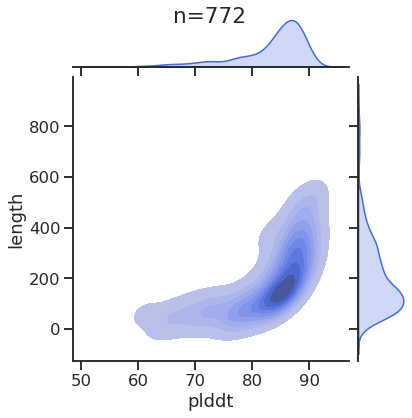

In [21]:
sns.set_theme(style="ticks")
sns.set_context("talk")


ax = sns.jointplot(
    data=summary_ref_af2,  fill=True, color = "royalblue", legend = False, 
    x="plddt", y="length",
    kind="kde"
)

nobs = summary_ref_af2['sequence'].value_counts().sum()

# Add it to the plot
#ax.fig.text(1,1,nobs,horizontalalignment='center',size='small',color='red')
ax.fig.suptitle("n="+str(nobs))

# Load references MSAs 

In [22]:
# Define dataset 
dataset = "homfam"
scores_dir = join("/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/",dataset,"evaluation/score/")

scores = pd.DataFrame()
for score_name in os.listdir(scores_dir):
    score_file = os.path.join(scores_dir,score_name)
    # Parse file
    if score_file.endswith(".scores"):
        # only keep references
        if "-ref" in score_file:
            score_df = pd.read_csv(score_file,sep = ";", header = None).drop(4, axis = 1)
            scores = pd.concat([scores, score_df])

scores.columns = ['name', 'sp', 'tc', 'column']

In [23]:
# -------------------------
#      Regressive
# -------------------------
regressive_scores = scores[scores.name.str.contains("regressive")]
regressive_scores[["family", "method", "bucket_size", "align_method", "tree_method"]] = regressive_scores.name.str.split(".", expand = True)

# -------------------------
#      Progressive
# -------------------------
progressive_scores = scores[scores.name.str.contains("progressive")]
progressive_scores[["family", "method", "align_method", "tree_method"]] = progressive_scores.name.str.split(".", expand = True)

# -------------------------
#      Dyanmic
# -------------------------
dynamic_scores = scores[scores.name.str.contains("dynamic")]
dynamic_scores[["family", "method", "bucket_size", "dynamicX_label","dynamicX_val","master_msa", "slave_msa", "tree_method"]] = dynamic_scores.name.str.split(".", expand = True)


# --------------   summary all -----------------
scores_df = pd.concat([regressive_scores, progressive_scores, dynamic_scores], ignore_index=True, sort=False)

scores_df.family = scores_df.family.str.replace("-ref","")
scores_df["benchmarking_dataset"] = dataset

stats_alignments_ref = get_stats(scores_df, summary_homfam_exthomfam)

df = stats_alignments_ref
df.nref = df.n_sequences * df.perc_ref_total /100 

/tmp/ipykernel_104487/2837001170.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regressive_scores[["family", "method", "bucket_size", "align_method", "tree_method"]] = regressive_scores.name.str.split(".", expand = True)
/tmp/ipykernel_104487/2837001170.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regressive_scores[["family", "method", "bucket_size", "align_method", "tree_method"]] = regressive_scores.name.str.split(".", expand = True)
/tmp/ipykernel_104487/2837001170.py:5: SettingWithCopyWarnin

In [28]:
df[df.align_method == "PROBAPAIR"]

,name,sp,tc,column,family,method,bucket_size,align_method,tree_method,dynamicX_label,...,subset,n_sequences,mean_length,min_length,max_length,file,size_group,perc_ref_total,approach,fam_approach
3,cryst-ref.progressive.PROBAPAIR.FAMSA-medoid,90.2,64.1,67.6,cryst,progressive,NaN,PROBAPAIR,FAMSA-medoid,NaN,...,combined,1160,80.807759,18,181,cryst,small,0.603448,progressive_PROBAPAIR_FAMSA-medoid,cryst_progressive_PROBAPAIR_FAMSA-medoid
12,scorptoxin-ref.progressive.PROBAPAIR.MBED,93.4,79.5,85.7,scorptoxin,progressive,NaN,PROBAPAIR,MBED,NaN,...,combined,363,53.256198,22,69,scorptoxin,small,2.203857,progressive_PROBAPAIR_MBED,scorptoxin_progressive_PROBAPAIR_MBED
13,scorptoxin-ref.progressive.PROBAPAIR.FAMSA-medoid,93.4,79.5,85.7,scorptoxin,progressive,NaN,PROBAPAIR,FAMSA-medoid,NaN,...,combined,363,53.256198,22,69,scorptoxin,small,2.203857,progressive_PROBAPAIR_FAMSA-medoid,scorptoxin_progressive_PROBAPAIR_FAMSA-medoid
23,KAS-ref.progressive.PROBAPAIR.FAMSA-medoid,88.2,73.2,79.3,KAS,progressive,NaN,PROBAPAIR,FAMSA-medoid,NaN,...,combined,2070,174.528019,17,388,KAS,small,0.289855,progressive_PROBAPAIR_FAMSA-medoid,KAS_progressive_PROBAPAIR_FAMSA-medoid
26,KAS-ref.progressive.PROBAPAIR.MBED,88.2,73.2,79.3,KAS,progressive,NaN,PROBAPAIR,MBED,NaN,...,combined,2070,174.528019,17,388,KAS,small,0.289855,progressive_PROBAPAIR_MBED,KAS_progressive_PROBAPAIR_MBED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,DMRL_synthase-ref.progressive.PROBAPAIR.MBED,92.4,72.8,82.7,DMRL_synthase,progressive,NaN,PROBAPAIR,MBED,NaN,...,combined,2099,140.590281,39,168,DMRL_synthase,small,0.238209,progressive_PROBAPAIR_MBED,DMRL_synthase_progressive_PROBAPAIR_MBED
1005,biotin_lipoyl-ref.progressive.PROBAPAIR.FAMSA-...,93.9,74.1,81.8,biotin_lipoyl,progressive,NaN,PROBAPAIR,FAMSA-medoid,NaN,...,combined,11833,71.892758,30,106,biotin_lipoyl,large,0.059157,progressive_PROBAPAIR_FAMSA-medoid,biotin_lipoyl_progressive_PROBAPAIR_FAMSA-medoid
1007,biotin_lipoyl-ref.progressive.PROBAPAIR.MBED,93.9,74.1,81.8,biotin_lipoyl,progressive,NaN,PROBAPAIR,MBED,NaN,...,combined,11833,71.892758,30,106,biotin_lipoyl,large,0.059157,progressive_PROBAPAIR_MBED,biotin_lipoyl_progressive_PROBAPAIR_MBED
1017,ricin-ref.progressive.PROBAPAIR.FAMSA-medoid,93.8,79.9,87.2,ricin,progressive,NaN,PROBAPAIR,FAMSA-medoid,NaN,...,combined,747,198.708166,44,267,ricin,small,0.937082,progressive_PROBAPAIR_FAMSA-medoid,ricin_progressive_PROBAPAIR_FAMSA-medoid


In [8]:
# Comparison 1: DYNAMIC w/ 3D
df_dyn_3d = df[df.approach == "dynamic_50_tcoffee_msa_famsa_msa_100000000_FAMSA-medoid"]
#df_dyn_3d["nref"] = df_dyn_3d.n_sequences * df_dyn_3d.perc_ref_total /100 

# Comparison 2: DYNAMIC w/ FAMSA 
df_dyn_famsa = df[df.approach == "dynamic_50_famsa_msa_famsa_msa_100000000_FAMSA-medoid"]

# Comparison 3: PROGRESSIVE w/ 3D 
df_prog_3d = df[df.approach == "progressive_3DCOFFEE_FAMSA-medoid"]
df_prog_3d_mbed = df[df.approach == "progressive_3DCOFFEE_MBED"]

# Comparison 3: PROGRESSIVE w/ 3D 
df_prog_3d_probapair = df[df.approach == "progressive_PROBAPAIR_FAMSA-medoid"]
df_prog_3d_probapair_mbed = df[df.approach == "progressive_PROBAPAIR_MBED"]


df_prog_3d_expresso = df[df.approach == "progressive_EXPRESSO_MBED"]


# Comparison 4: PROGRESSIVE w/ FAMSA
df_prog_famsa = df[df.approach == "progressive_FAMSA_FAMSA-medoid"]

df = pd.concat([df_dyn_3d, df_dyn_famsa, df_prog_3d, df_prog_famsa])

In [9]:
# Do 3D progressive and 3D dyanmic give the same (aka --> any bug in dynamic --> NO)
df_dyn_3d_red = df_dyn_3d[["family","tc"]]
df_prog_3d_red = df_prog_3d[["family", "tc"]]
df_3d_all = pd.merge(df_dyn_3d_red, df_prog_3d_red, on = "family")
np.array(df_3d_all.tc_x == df_3d_all.tc_y)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [10]:
# Do 3D COFFEE and 3D PROBAPAIR give the same?  no (aka --> WE ARE USING THE STRUCTURES)
df1_red = df_dyn_3d[["family","tc"]]
df2_red = df_prog_3d_probapair[["family", "tc"]]
df_all = pd.merge(df1_red, df2_red, on = "family")
np.array(df_all.tc_x == df_all.tc_y)

array([], dtype=bool)

In [11]:
# Do 3D progressive and 3D dyanmic give the same (aka --> any bug in dynamic --> NO)
df_dyn_famsa_red = df_dyn_famsa[["family","tc"]]
df_prog_famsa_red = df_prog_famsa[["family", "tc"]]
df_famsa_all = pd.merge(df_dyn_famsa_red, df_prog_famsa_red, on = "family")
np.array(df_famsa_all.tc_x ==df_famsa_all.tc_y)

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True, False,  True,  True, False,  True, False, False,  True,
       False,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True, False, False,  True,  True,  True,
       False, False, False,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True])

## Check that we get the same results with 3D dynamic and 3D progressive

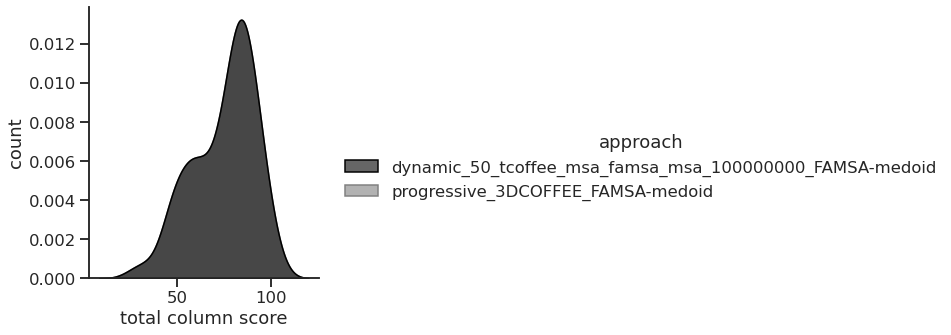

In [12]:
df_dyn_test = pd.concat([df_dyn_3d, df_prog_3d])
df_dyn_test

# Set your custom color palette
sns.set_palette(sns.color_palette(["black", "grey"]))
sns.displot(data = df_dyn_test, x="tc", hue = "approach", kind = "kde", fill = "approach", alpha = 0.6).set(xlabel = "total column score", ylabel = "count")

In [13]:
df_d_r = pd.merge(df_dyn, df_reg, on = ["family"] )
df_d_r["diff_tc"] = df_d_r.tc_x - df_d_r.tc_y 
df_d_r["diff_sp"] = df_d_r.sp_x - df_d_r.sp_y 
df_d_r["perc_change_tc"]= df_d_r.diff_tc *100/ abs(df_d_r.tc_y) 

NameError: name 'df_dyn' is not defined

# Align reference sequences alone 


## 1: How well do we do?
### Check that structural aligner does better than standard one

In [144]:
df = df[df.method.isin(["dynamic","progressive"])]
df["structure"] = "no_structure"
df.loc[df.method == "dynamic", 'structure'] = "structure"
df

,name,sp,tc,column,family,method,bucket_size,align_method,tree_method,dynamicX_label,...,n_sequences,mean_length,min_length,max_length,file,size_group,perc_ref_total,approach,fam_approach,structure
4,cryst-ref.dynamic.50.dynamicX.100000000.tcoffe...,87.8,56.4,58.2,cryst,dynamic,50,NaN,FAMSA-medoid,dynamicX,...,1160,80.807759,18,181,cryst,small,0.603448,dynamic_50_tcoffee_msa_famsa_msa_100000000_FAM...,cryst_dynamic_50_tcoffee_msa_famsa_msa_1000000...,structure
13,scorptoxin-ref.dynamic.50.dynamicX.100000000.t...,95.1,79.5,85.6,scorptoxin,dynamic,50,NaN,FAMSA-medoid,dynamicX,...,363,53.256198,22,69,scorptoxin,small,2.203857,dynamic_50_tcoffee_msa_famsa_msa_100000000_FAM...,scorptoxin_dynamic_50_tcoffee_msa_famsa_msa_10...,structure
17,KAS-ref.dynamic.50.dynamicX.100000000.tcoffee_...,94.5,85.2,89.8,KAS,dynamic,50,NaN,FAMSA-medoid,dynamicX,...,2070,174.528019,17,388,KAS,small,0.289855,dynamic_50_tcoffee_msa_famsa_msa_100000000_FAM...,KAS_dynamic_50_tcoffee_msa_famsa_msa_100000000...,structure
26,hom-ref.dynamic.50.dynamicX.100000000.tcoffee_...,98.5,81.2,97.1,hom,dynamic,50,NaN,FAMSA-medoid,dynamicX,...,12037,53.495140,12,79,hom,large,0.066462,dynamic_50_tcoffee_msa_famsa_msa_100000000_FAM...,hom_dynamic_50_tcoffee_msa_famsa_msa_100000000...,structure
32,p450-ref.dynamic.50.dynamicX.100000000.tcoffee...,84.1,47.1,60.9,p450,dynamic,50,NaN,FAMSA-medoid,dynamicX,...,21013,331.505877,21,557,p450,large,0.057108,dynamic_50_tcoffee_msa_famsa_msa_100000000_FAM...,p450_dynamic_50_tcoffee_msa_famsa_msa_10000000...,structure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,hormone_rec-ref.progressive.FAMSA.FAMSA-medoid,77.1,50.5,64.5,hormone_rec,progressive,NaN,FAMSA,FAMSA-medoid,NaN,...,3509,188.562268,32,285,hormone_rec,small,0.142491,progressive_FAMSA_FAMSA-medoid,hormone_rec_progressive_FAMSA_FAMSA-medoid,no_structure
595,il8-ref.progressive.FAMSA.FAMSA-medoid,93.2,63.6,72.2,il8,progressive,NaN,FAMSA,FAMSA-medoid,NaN,...,1073,63.762349,18,82,il8,small,1.025163,progressive_FAMSA_FAMSA-medoid,il8_progressive_FAMSA_FAMSA-medoid,no_structure
601,DMRL_synthase-ref.progressive.FAMSA.FAMSA-medoid,91.1,71.6,82.0,DMRL_synthase,progressive,NaN,FAMSA,FAMSA-medoid,NaN,...,2099,140.590281,39,168,DMRL_synthase,small,0.238209,progressive_FAMSA_FAMSA-medoid,DMRL_synthase_progressive_FAMSA_FAMSA-medoid,no_structure
606,biotin_lipoyl-ref.progressive.FAMSA.FAMSA-medoid,95.3,81.2,84.2,biotin_lipoyl,progressive,NaN,FAMSA,FAMSA-medoid,NaN,...,11833,71.892758,30,106,biotin_lipoyl,large,0.059157,progressive_FAMSA_FAMSA-medoid,biotin_lipoyl_progressive_FAMSA_FAMSA-medoid,no_structure


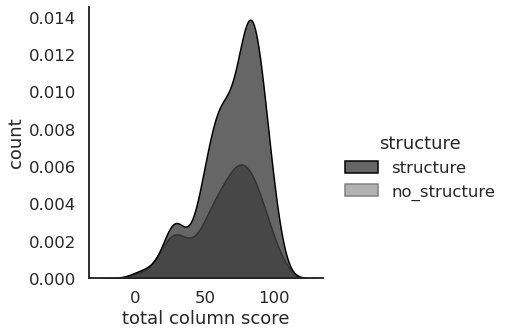

In [129]:
# Set your custom color palette
sns.set_palette(sns.color_palette(["black", "grey"]))
sns.displot(data = df, x="tc", hue = "structure", kind = "kde", fill = "structure", alpha = 0.6).set(xlabel = "total column score", ylabel = "count")

[Text(0, 0.5, 'structure SP - not structure SP'),
 Text(0.5, 0, ''),
 [Text(0, 0, ''),
  Text(1, 0, ''),
  Text(2, 0, ''),
  Text(3, 0, ''),
  Text(4, 0, ''),
  Text(5, 0, ''),
  Text(6, 0, ''),
  Text(7, 0, ''),
  Text(8, 0, ''),
  Text(9, 0, ''),
  Text(10, 0, ''),
  Text(11, 0, ''),
  Text(12, 0, ''),
  Text(13, 0, ''),
  Text(14, 0, ''),
  Text(15, 0, ''),
  Text(16, 0, ''),
  Text(17, 0, ''),
  Text(18, 0, ''),
  Text(19, 0, ''),
  Text(20, 0, ''),
  Text(21, 0, ''),
  Text(22, 0, ''),
  Text(23, 0, ''),
  Text(24, 0, ''),
  Text(25, 0, ''),
  Text(26, 0, ''),
  Text(27, 0, ''),
  Text(28, 0, ''),
  Text(29, 0, ''),
  Text(30, 0, ''),
  Text(31, 0, ''),
  Text(32, 0, ''),
  Text(33, 0, ''),
  Text(34, 0, ''),
  Text(35, 0, ''),
  Text(36, 0, ''),
  Text(37, 0, ''),
  Text(38, 0, ''),
  Text(39, 0, ''),
  Text(40, 0, ''),
  Text(41, 0, ''),
  Text(42, 0, ''),
  Text(43, 0, ''),
  Text(44, 0, ''),
  Text(45, 0, ''),
  Text(46, 0, ''),
  Text(47, 0, ''),
  Text(48, 0, ''),
  Text(49,

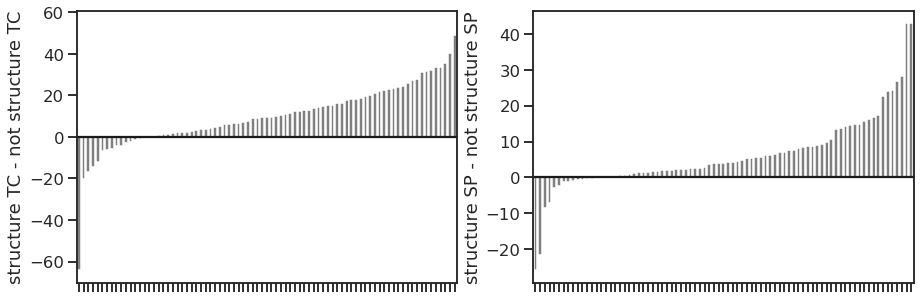

In [45]:
# Set up the matplotlib figure
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 5), sharex=True)

# Center the data to make it diverging
sns.barplot(x=df_d_r.diff_tc, y=df_d_r.diff_tc, color ="grey", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set(ylabel="structure TC - not structure TC", xlabel = "", xticklabels="")

# Center the data to make it diverging
sns.barplot(x=df_d_r.diff_sp, y=df_d_r.diff_sp, color ="grey", ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
ax2.set(ylabel="structure SP - not structure SP", xlabel = "", xticklabels="")

In [46]:
# Which are the ones for which we do not get ? 
family_worst = list(df_d_r[df_d_r.diff_tc < 0].family)
df_d_r["diff_qualitatively"] = "better"
df_d_r.loc[df_d_r.diff_tc < 0, 'diff_qualitatively'] = "worst"
df_d_r.diff_qualitatively.value_counts()
df_d_r = pd.merge(df_d_r, summary_ref, on = "family")

<AxesSubplot:xlabel='diff_qualitatively', ylabel='n_sequences_x'>

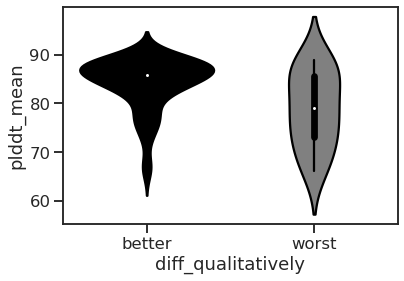

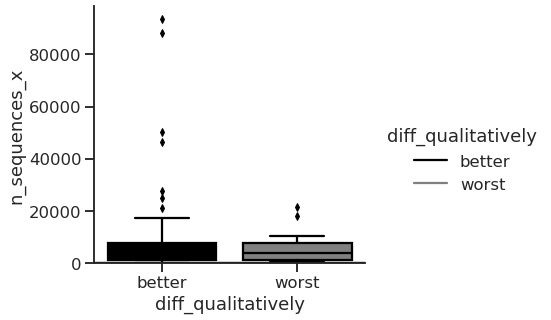

In [47]:
sns.violinplot(data = df_d_r, y = "plddt_mean", x = "diff_qualitatively")
sns.displot(df_d_r, x = "n_sequences_x", hue = "diff_qualitatively", kind = "kde")
sns.boxplot(data = df_d_r, y = "n_sequences_x", x = "diff_qualitatively")


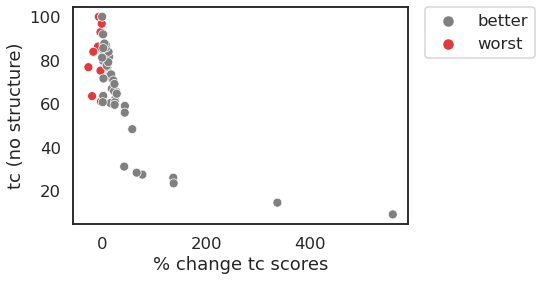

In [12]:
# Create an array with the colors you want to use
colors = ["grey", "#E13A3A"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
sns.scatterplot(data = df_d_r, x = "perc_change_tc", y = "tc_y", hue = "diff_qualitatively").set(ylabel = "tc (no structure)", xlabel = "% change tc scores")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


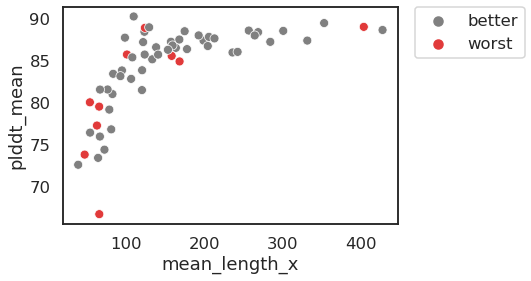

In [13]:
# Create an array with the colors you want to use
colors = ["grey", "#E13A3A"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
sns.scatterplot(data = df_d_r, x = "mean_length_x", y = "plddt_mean", hue = "diff_qualitatively")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


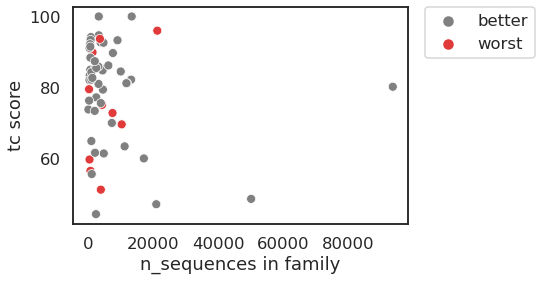

In [14]:
# Create an array with the colors you want to use
colors = ["grey", "#E13A3A"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
sns.scatterplot(data = df_d_r, y = "tc_x", x = "n_sequences_x", hue = "diff_qualitatively").set(xlabel  ="n_sequences in family", ylabel = "tc score")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


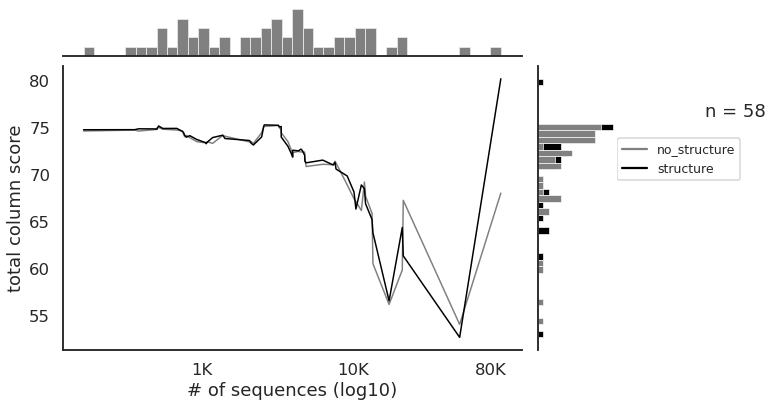

In [16]:
# -------------------------------
#           Plot TC 
# ------------------------------

sns.set_palette(sns.color_palette(["grey", "black"]))

df["n_sequences_log"] = np.log10( df["n_sequences"] )  


x = df.n_sequences_log
y = cumavg(df.sort_values(by=["n_sequences_log"], ascending = False)["tc"])
hue = df["structure"]


ax = sns.JointGrid(x = x, y = y, hue = hue)
ax.plot_joint(sns.lineplot,  linewidth=1.5)
ax.plot_marginals(sns.histplot, color="#03051A", alpha=1, bins=40)
ax.ax_joint.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=5.8, fontsize = "x-small")
ax.fig.set_figwidth(10)
ax.fig.set_figheight(6)

ax.ax_joint.set(xlabel = "# of sequences (log10)", ylabel = "total column score")
ax.ax_joint.set_xticks(np.log10([1000,10000,80000]))
ax.ax_joint.set_xticklabels(["1K", "10K", "80K"]) 
plt.title("n = "+str(len(fams)), x=2.5, y=0.8)


outdir = "../../../data/structural_regression/plots/03_benchmarkDynamic/" 
plt.savefig(os.path.join(outdir, "01_seq_vs_tc.pdf"))

# 2: Are the reference sequences of big families more challenging to align even when alone?
### is it dependent on sequence length? 

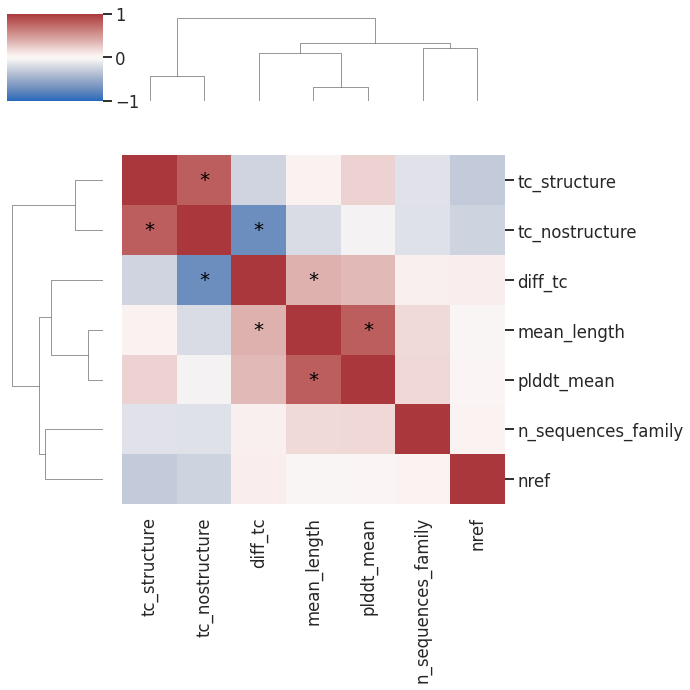

In [655]:
df_correlation = df[["sp","tc", "n_sequences", "nref", "mean_length", "method"]]

df_correlation = df_d_r[["diff_tc","tc_x","tc_y",  "n_sequences_x", "nref_x", "mean_length_x", "plddt_mean"]]

df_correlation.columns = ["diff_tc", "tc_structure", "tc_nostructure", "n_sequences_family", "nref", "mean_length", "plddt_mean"]
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests
def get_correlations(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how="outer")
    correlations = dfcols.transpose().join(dfcols, how="outer")
    for ix, r in enumerate(df.columns):
        for jx, c in enumerate(df.columns):
            sp = spearmanr(df[r], df[c])
            correlations[c][r] = sp[0]
            pvalues[c][r] = sp[1] if ix > jx else np.nan  # Only store values below the diagonal
    return correlations.astype("float"), pvalues.astype("float")


correlations, uncorrected_p_values = get_correlations(df_correlation)

# Correct p-values for multiple testing and check significance (True if the corrected p-value < 0.05)
shape = uncorrected_p_values.values.shape
significant_matrix = multipletests(uncorrected_p_values.values.flatten())[0].reshape(
    shape
)

# Here we start plotting
g = sns.clustermap(correlations, cmap="vlag", vmin=-1, vmax=1)

# Here labels on the y-axis are rotated
for tick in g.ax_heatmap.get_yticklabels():
    tick.set_rotation(0)

# Here we add asterisks onto cells with signficant correlations
for i, ix in enumerate(g.dendrogram_row.reordered_ind):
    for j, jx in enumerate(g.dendrogram_row.reordered_ind):
        if i != j:
            text = g.ax_heatmap.text(
                j + 0.5,
                i + 0.5,
                "*" if significant_matrix[ix, jx] or significant_matrix[jx, ix] else "",
                ha="center",
                va="center",
                color="black",
            )
            text.set_fontsize(20)

# Save a high-res copy of the image to disk
plt.tight_layout()
plt.savefig("clustermap.png", dpi=200)